In [1]:
import os
import pandas as pd
import pickle
from matplotlib import pyplot as plt
import numpy as np
from ribbn_scripts.processing.get_offset import get_offset
from ribbn_scripts.processing.phase_estimate import multitag_multifreq_phase_estimation
from ribbn_scripts.processing.localization import estimate_dph_df,direct_distance_estimate,estimate_k,unwrap_phases
from ribbn_scripts.ref_functions.spec_functions import read_network_analyzer_file, get_theta, get_amplitude, s2z
import pickle
import json

In [2]:
df_all=None
file_names = sorted([f for f in os.listdir("dataframes") if f[0] != '.'], key=lambda x: int(x.split('.')[0]))
exps_done=0
for file_name in file_names:
    dist_idx=int(file_name.split(".")[0])
    with open(f'dataframes/{file_name}', "rb") as f:
        print(file_name)
        _df = pickle.load(f)
        if df_all is None:
            df_all=_df
        else:
            _df["Run Exp Num"]=exps_done
            df_all = pd.concat([df_all, _df], ignore_index=True)
    exps_done=len(df_all["Run Exp Num"].unique())
    # print(exps_done, df_all["Run Exp Num"].unique())
df_all

0.df
1.df
2.df
3.df


,Rx,Tx,MPP Start Time (s),MPP Stop Time (s),Voltages (mV),Frequency (MHz),Run Exp Num,NumMPPs
0,2,1,1.763514e+09,1.763514e+09,"[32.62, 93.04, 93.04, 92.97, 93.04, 92.97, 92....",775,0,5
1,3,1,1.763514e+09,1.763514e+09,"[73.05, 11.79, 11.94, 11.86, 11.71, 11.94, 11....",775,0,5
2,4,1,1.763514e+09,1.763514e+09,"[37.19, 19.11, 19.87, 20.33, 18.35, 18.5, 18.3...",775,0,5
3,5,1,1.763514e+09,1.763514e+09,"[8.51, 10.26, 10.41, 10.26, 10.03, 10.26, 10.8...",775,0,5
4,1,2,1.763514e+09,1.763514e+09,"[13.85, 11.33, 11.02, 11.48, 11.79, 11.25, 11....",775,0,5
...,...,...,...,...,...,...,...,...
1835,5,4,1.763515e+09,1.763515e+09,"[6.22, 4.84, 4.84, 4.84, 4.84, 4.84, 4.84, 4.8...",995,3,5
1836,1,5,1.763515e+09,1.763515e+09,"[14.08, 13.16, 13.39, 13.39, 13.47, 13.31, 13....",995,3,5
1837,2,5,1.763515e+09,1.763515e+09,"[29.41, 29.03, 29.11, 28.19, 28.04, 28.04, 28....",995,3,5
1838,3,5,1.763515e+09,1.763515e+09,"[82.67, 83.28, 81.75, 84.27, 83.28, 82.13, 85....",995,3,5


In [3]:
with open("../tag_name_mapping.json", 'r') as f:
    tag_name_mapping=json.load(f)
tag_name_mapping

{'Tag1': 'v32-4',
 'Tag2': 'v32-5',
 'Tag3': 'v31-2',
 'Tag4': 'v31-1',
 'Tag5': 'v32-3'}

In [4]:
# time_per_phase = 10/1000  # s
# num_phases=6
# num_mpps=df_all.iloc[0]['NumMPPs']
# sampling_rate=1000
# plotting=False
# ver_lines = [0] + [ (time_per_phase-time_per_phase*0.01) * sampling_rate * (i + 1) for i in range(num_phases*num_mpps)]

# processedDF=pd.DataFrame(columns=["Rx","Tx", "Voltages (mV)", "Phase1","Phase3","Phase4","Phase6","Phase7","Phase8",
#                                 "Frequency (MHz)", "Run Exp Num", "NumMPPs"])
# processedDF_aggregated=pd.DataFrame(columns=["Rx","Tx","phase", "median", "std","freq", "dist", 'delta', "Experiment Number", "Unique Exp Number"])



# unique_exp_no=0
# phase_order=[1,3,4,6,7,8]

# for df_idx in range(len(df_all)):

#     voltages=df_all.iloc[df_idx]['Voltages (mV)']
#     phase_medians={
#         1:[],
#         3:[],
#         4:[],
#         6:[],
#         7:[],
#         8:[],
#     }
#     if plotting:
#         plt.figure(figsize=(15,5))
#     for idx,v in enumerate(ver_lines):
#         if idx<len(ver_lines)-1:
#             phase_medians[phase_order[int(idx%num_phases)]].append(np.median(voltages[int(ver_lines[idx]):int(ver_lines[idx+1])]))   
#         if plotting:
#             # plt.subplot(len(df_all)//3+1, 3, df_idx+1)
#             if idx%num_phases==0:
#                 plt.axvline(x=v, color='b', linestyle='-')
#             else:
#                 plt.axvline(x=v, color='r', linestyle='--')
#     entry={
#         "Rx": df_all.iloc[df_idx]["Rx"],
#         "Tx":df_all.iloc[df_idx]["Tx"],
#         "Voltages (mV)":df_all.iloc[df_idx]["Voltages (mV)"],
#         "Phase1":phase_medians[1],
#         "Phase3":phase_medians[3],
#         "Phase4":phase_medians[4],
#         "Phase6":phase_medians[6],
#         "Phase7":phase_medians[7],
#         "Phase8":phase_medians[8],
#         "Frequency (MHz)":df_all.iloc[df_idx]["Frequency (MHz)"],
#         "Run Exp Num":df_all.iloc[df_idx]["Run Exp Num"],
#         "NumMPPs":df_all.iloc[df_idx]["NumMPPs"],
#     }
#     for phase in phase_order:
#         entry_aggregated={
#             "Rx":df_all.iloc[df_idx]["Rx"],
#             "Tx":df_all.iloc[df_idx]["Tx"],
#             "phase": str(phase),
#             "median": np.mean(phase_medians[phase]), # mean of medians
#             "std": np.std(phase_medians[phase]),
#             "freq": df_all.iloc[df_idx]["Frequency (MHz)"]*1e6,
#             'delta': max(phase_medians[phase])-min(phase_medians[phase]),
#             "Experiment Number":df_all.iloc[df_idx]["Run Exp Num"],
#             "Unique Exp Number":unique_exp_no,
#             "allVoltages": phase_medians[phase]
#         }
#         processedDF_aggregated=pd.concat([processedDF_aggregated, pd.DataFrame([entry_aggregated])], ignore_index=True)
#     unique_exp_no+=1
    
#     # # Identify and print bad MPPs
#     # bad=False
#     # for k in phase_medians.keys():
#     #     assert(len(phase_medians[k])==num_mpps)
#     #     if np.std(phase_medians[k])>1:
#     #         print(f"<== Bad data found at {df_idx} df_idx at phase {k}.", end="\t")
#     #         print(f"Num vals: {len(phase_medians[k])}, mean: {np.mean(phase_medians[k])}, stdev: {np.std(phase_medians[k])} ==>")
#     #         bad=True
#     # if bad and plotting:
#     #     plt.plot(voltages,'.')
#     #     plt.title(df_idx)
#     #     plt.tight_layout()
#     #     plt.ylim([np.percentile(voltages, 1), np.percentile(voltages, 99)])
#     #     plt.savefig(f"badplots/{df_idx}.pdf")
#     #     plt.clf()
#     # elif not bad and plotting:
#     #     plt.clf()
    
    
#     processedDF=pd.concat([processedDF,pd.DataFrame([entry])],ignore_index=True)
    
    
#     # if df_idx>20:
#     #     break   
# # if plotting:
# #     plt.show()
    
with open("processedDF.pkl", 'rb') as f:
    processedDF=pickle.load(f)
    
with open("processedDF_aggregated.pkl", 'rb') as f:
    processedDF_aggregated=pickle.load(f)


In [5]:
with open("processedDF.pkl", 'wb') as f:
    pickle.dump(processedDF,f)
processedDF

,Rx,Tx,Voltages (mV),Phase1,Phase3,Phase4,Phase6,Phase7,Phase8,Frequency (MHz),Run Exp Num,NumMPPs
0,2,1,"[32.62, 93.04, 93.04, 92.97, 93.04, 92.97, 92....","[92.97, 92.81, 92.89, 92.93, 92.74]","[93.995, 93.805, 93.91999999999999, 93.995, 94...","[94.72, 94.60499999999999, 94.53, 94.72, 94.87]","[94.60499999999999, 94.645, 94.75999999999999,...","[94.64, 94.57, 94.07, 94.225, 94.34]","[90.75, 90.525, 90.41, 90.64, 90.75]",775,0,5
1,3,1,"[73.05, 11.79, 11.94, 11.86, 11.71, 11.94, 11....","[11.79, 11.79, 11.75, 11.75, 11.75]","[11.94, 11.86, 11.86, 11.86, 11.86]","[12.02, 11.94, 11.86, 11.94, 12.02]","[11.94, 12.02, 11.94, 12.02, 12.02]","[12.02, 12.09, 12.015, 12.129999999999999, 12....","[12.09, 12.02, 11.94, 11.94, 12.02]",775,0,5
2,4,1,"[37.19, 19.11, 19.87, 20.33, 18.35, 18.5, 18.3...","[18.5, 18.35, 18.2, 18.310000000000002, 18.16]","[19.685, 18.54, 18.310000000000002, 18.465, 18...","[19.415, 18.54, 18.689999999999998, 18.73, 18....","[19.0, 18.88, 18.77, 18.92, 19.04]","[19.04, 19.26, 18.96, 18.96, 19.265]","[19.11, 19.115000000000002, 19.075, 19.0, 19.11]",775,0,5
3,5,1,"[8.51, 10.26, 10.41, 10.26, 10.03, 10.26, 10.8...","[10.26, 9.96, 9.88, 10.03, 9.84]","[10.34, 10.07, 9.88, 9.84, 9.84]","[10.219999999999999, 9.88, 10.03, 9.88, 10.265]","[10.07, 9.995000000000001, 10.11, 10.07, 10.07]","[10.3, 10.57, 10.225, 10.41, 10.3]","[10.760000000000002, 10.68, 10.57, 10.68, 10.87]",775,0,5
4,1,2,"[13.85, 11.33, 11.02, 11.48, 11.79, 11.25, 11....","[11.41, 11.25, 10.11, 10.149999999999999, 10.03]","[12.055, 12.055, 10.87, 10.835, 10.8]","[8.43, 8.51, 7.29, 7.36, 7.36]","[12.63, 12.665, 11.86, 11.86, 11.899999999999999]","[13.24, 13.31, 12.129999999999999, 12.21, 12.17]","[13.08, 11.98, 12.02, 11.94, 12.02]",775,0,5
...,...,...,...,...,...,...,...,...,...,...,...,...
1835,5,4,"[6.22, 4.84, 4.84, 4.84, 4.84, 4.84, 4.84, 4.8...","[4.84, 7.0600000000000005, 7.63, 8.28, 7.82]","[4.96, 6.33, 6.484999999999999, 7.02, 6.905]","[4.84, 6.675, 6.14, 6.6, 7.175]","[5.34, 7.67, 9.27, 7.9750000000000005, 7.43999...","[5.875, 7.82, 8.58, 9.12, 7.74]","[7.67, 7.97, 7.9350000000000005, 7.895, 7.48]",995,3,5
1836,1,5,"[14.08, 13.16, 13.39, 13.39, 13.47, 13.31, 13....","[13.39, 13.24, 13.24, 13.16, 13.275]","[13.16, 13.16, 13.120000000000001, 13.31, 13.045]","[13.350000000000001, 13.39, 13.43, 13.31, 13.31]","[13.43, 13.47, 13.39, 13.504999999999999, 13.5...","[13.39, 13.39, 13.350000000000001, 13.43, 13.39]","[13.31, 13.31, 13.31, 13.350000000000001, 13.24]",995,3,5
1837,2,5,"[29.41, 29.03, 29.11, 28.19, 28.04, 28.04, 28....","[28.27, 28.0, 28.535, 28.689999999999998, 28.42]","[29.225, 29.07, 28.305, 28.689999999999998, 28.0]","[28.15, 28.765, 28.38, 27.96, 29.41]","[29.45, 28.65, 29.07, 28.765, 28.42]","[27.810000000000002, 28.19, 27.58, 28.23, 29.07]","[28.115000000000002, 28.84, 29.185000000000002...",995,3,5
1838,3,5,"[82.67, 83.28, 81.75, 84.27, 83.28, 82.13, 85....","[83.28, 82.745, 83.35, 82.82, 83.43]","[83.08500000000001, 84.305, 83.58, 84.95500000...","[83.735, 83.53999999999999, 82.66499999999999,...","[82.055, 83.81, 83.00999999999999, 83.35, 81.45]","[83.695, 82.44, 81.405, 82.475, 82.36500000000...","[83.12, 83.425, 82.895, 83.545, 82.09]",995,3,5


In [6]:
with open("processedDF_aggregated.pkl", 'wb') as f:
    pickle.dump(processedDF_aggregated,f)
processedDF_aggregated

,Rx,Tx,phase,median,std,freq,dist,delta,Experiment Number,Unique Exp Number,allVoltages
0,2,1,1,92.868,0.083042,775000000.0,NaN,0.230,0,0,"[92.97, 92.81, 92.89, 92.93, 92.74]"
1,2,1,3,93.949,0.080461,775000000.0,NaN,0.225,0,0,"[93.995, 93.805, 93.91999999999999, 93.995, 94..."
2,2,1,4,94.689,0.115776,775000000.0,NaN,0.340,0,0,"[94.72, 94.60499999999999, 94.53, 94.72, 94.87]"
3,2,1,6,94.744,0.104709,775000000.0,NaN,0.270,0,0,"[94.60499999999999, 94.645, 94.75999999999999,..."
4,2,1,7,94.369,0.212047,775000000.0,NaN,0.570,0,0,"[94.64, 94.57, 94.07, 94.225, 94.34]"
...,...,...,...,...,...,...,...,...,...,...,...
11035,4,5,3,40.055,1.202797,995000000.0,NaN,3.240,3,1839,"[37.92, 39.56, 41.16, 40.97, 40.665000000000006]"
11036,4,5,4,41.090,0.715353,995000000.0,NaN,1.985,3,1839,"[41.31, 39.785, 41.769999999999996, 40.93, 41...."
11037,4,5,6,40.596,0.533867,995000000.0,NaN,1.485,3,1839,"[41.045, 40.93, 40.665, 39.56, 40.78]"
11038,4,5,7,40.032,0.775929,995000000.0,NaN,2.095,3,1839,"[41.235, 39.64, 39.519999999999996, 40.625, 39..."


In [7]:
processedDF_aggregated[processedDF_aggregated["Experiment Number"]==1]

,Rx,Tx,phase,median,std,freq,dist,delta,Experiment Number,Unique Exp Number,allVoltages
2760,2,1,1,85.051,0.376290,775000000.0,NaN,0.990,1,460,"[84.57, 85.105, 84.685, 85.33500000000001, 85.56]"
2761,2,1,3,86.558,0.311971,775000000.0,NaN,0.835,1,460,"[86.33, 86.71000000000001, 86.785, 86.065, 86.9]"
2762,2,1,4,86.891,0.287965,775000000.0,NaN,0.840,1,460,"[87.09, 86.4, 86.935, 87.24, 86.79]"
2763,2,1,6,87.205,0.429465,775000000.0,NaN,1.030,1,460,"[87.50999999999999, 87.7, 86.71000000000001, 8..."
2764,2,1,7,86.664,0.280168,775000000.0,NaN,0.800,1,460,"[86.215, 86.63, 86.56, 87.015, 86.9]"
...,...,...,...,...,...,...,...,...,...,...,...
5515,4,5,3,43.344,1.132283,995000000.0,NaN,2.670,1,919,"[42.61, 44.44499999999999, 44.974999999999994,..."
5516,4,5,4,42.953,0.222207,995000000.0,NaN,0.690,1,919,"[42.99, 43.3, 42.99, 42.61, 42.875]"
5517,4,5,6,44.052,0.335255,995000000.0,NaN,1.035,1,919,"[43.6, 43.94499999999999, 43.985, 44.635000000..."
5518,4,5,7,44.144,0.275489,995000000.0,NaN,0.720,1,919,"[44.405, 44.44, 43.94499999999999, 44.21, 43.72]"


In [8]:
freq_range=np.array(range(775,1000,10))*1e6
all_freqs, selected_experiments_all = multitag_multifreq_phase_estimation(freq_range,processedDF_aggregated,correction_factor=0,plot=False, all_available_tags=["1", "2", "3", "4", "5"], tag_name_mappings=tag_name_mapping)

# with open("no_correction_all_errs.pkl",'wb') as f:
#     pickle.dump(all_errors,f)
    
with open("no_correction_all_phases.pkl",'wb') as f:
    pickle.dump(all_freqs,f)

# with open("no_correction_all_phases_unwrapped.pkl",'wb') as f:
#     pickle.dump(all_freqs_unwrapped,f)    

# with open("theoretical_phase.pkl",'wb') as f:
#     pickle.dump(all_freqs_theoretical,f)    

[-0.7649948270430423, 3.058782179560396]
[-2.042689307390112, 2.8317446341529107]
[-2.1410093470256273, 2.641621587111629]
[2.969176513131156, 2.0389349662426244]
[1.5687522333681234, 0.9532128690125229]
[1.2528829137738586, 1.2071830565117516]
[2.8848396278524118, -2.4807972448763635]
[0.3410942503755507, 0.7093747063225432]
[-0.5483053426663269, -0.7210123183334863]
[0.8032713836685947, -0.4538154124679913]
[-0.7407779304976266, 3.0075985962601095]
[-1.8117735151778986, 2.183240613364045]
[-2.6374324871380845, 2.113760253863245]
[-1.0165427870290316, 0.3198775935637078]
[1.6551233518520656, 0.9787102430194711]
[1.520076846364554, 1.0793272413925563]
[-0.28948885079132414, -3.067461467032046]
[0.27555811390259316, 0.39200607857523667]
[0.4309561125912179, 2.8533928424503525]
[0.17343094927825736, 2.8999655954378545]
[-0.6846361821499587, 3.0111502412384454]
[-2.7121035098806234, 2.569683498479796]
[-2.9475825144579675, 2.4598163284374994]
[2.761443058660445, -0.0868476650798629]
[1.68

In [9]:
all_freqs[915e6][1][0]['1-2']

np.float64(2.1910575281916205)

In [10]:
def getMPPSignalPlot(exp_no, tag1, tag2, freq):
    # freq in mhz
    plt.subplot(2,1,1)
    plt.plot(processedDF[(processedDF['Run Exp Num']==exp_no) & (processedDF['Rx']==tag1) & (processedDF['Tx']==tag2) & (processedDF['Frequency (MHz)']==freq)]["Voltages (mV)"].to_numpy()[0])
    plt.title(f"Rx={tag1}, Tx={tag2}")
    
    plt.subplot(2,1,2)
    v=processedDF[(processedDF['Run Exp Num']==exp_no) & (processedDF['Rx']==tag2) & (processedDF['Tx']==tag1) & (processedDF['Frequency (MHz)']==freq)]["Voltages (mV)"].to_numpy()[0]
    plt.plot(v)
    plt.ylim([np.percentile(v,1), np.percentile(v,99)])
    plt.title(f"Rx={tag2}, Tx={tag1}")
    
    plt.suptitle(f"Exp={exp_no}, freq={freq}")
    plt.tight_layout()
    plt.show()

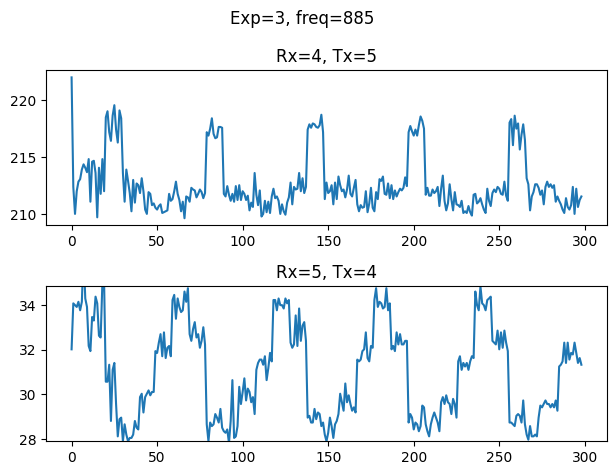

In [11]:
getMPPSignalPlot(3, 4, 5, 885)

In [12]:
plt.figure(figsize=(10,3))
link1='1-5'
link2='4-5'
l1_ph=[]
l2_ph=[]
for freq in all_freqs.keys():
    exp1=4
    exp2=7
    l1_ph.append(all_freqs[freq][exp1][0][link1])
    l2_ph.append(all_freqs[freq][exp2][0][link2])
    
plt.plot(list(all_freqs.keys()),l1_ph, '.-', label="1-5, exp 0")
plt.plot(list(all_freqs.keys()),l2_ph, '.-', label="4-5, exp 0")
plt.xlabel("Freq (Hz)")
plt.ylabel("Phase (rad)")
plt.show()
# what is the relation between phase change and t2t distance.............
# get distance matrix from slam info
# ability to plot adc voltages for given experiment number and frequency.

KeyError: 4

<Figure size 1000x300 with 0 Axes>

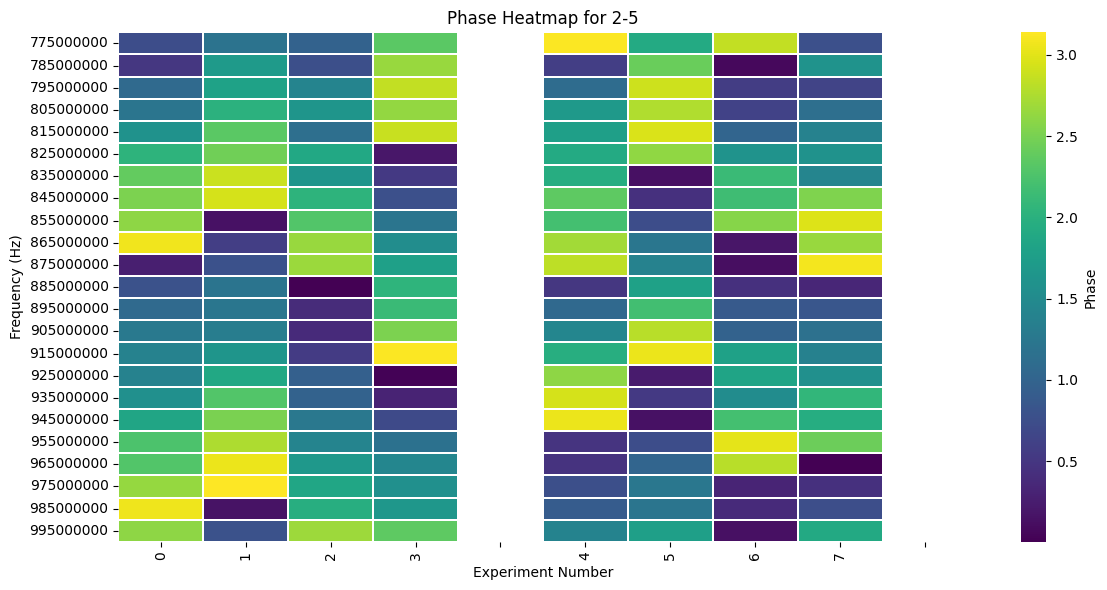

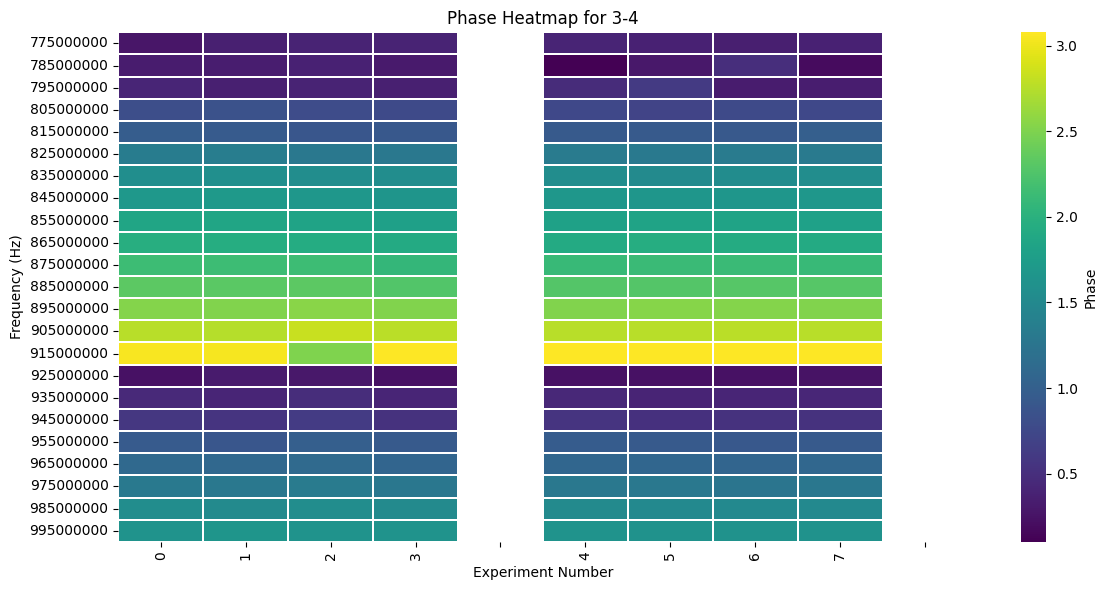

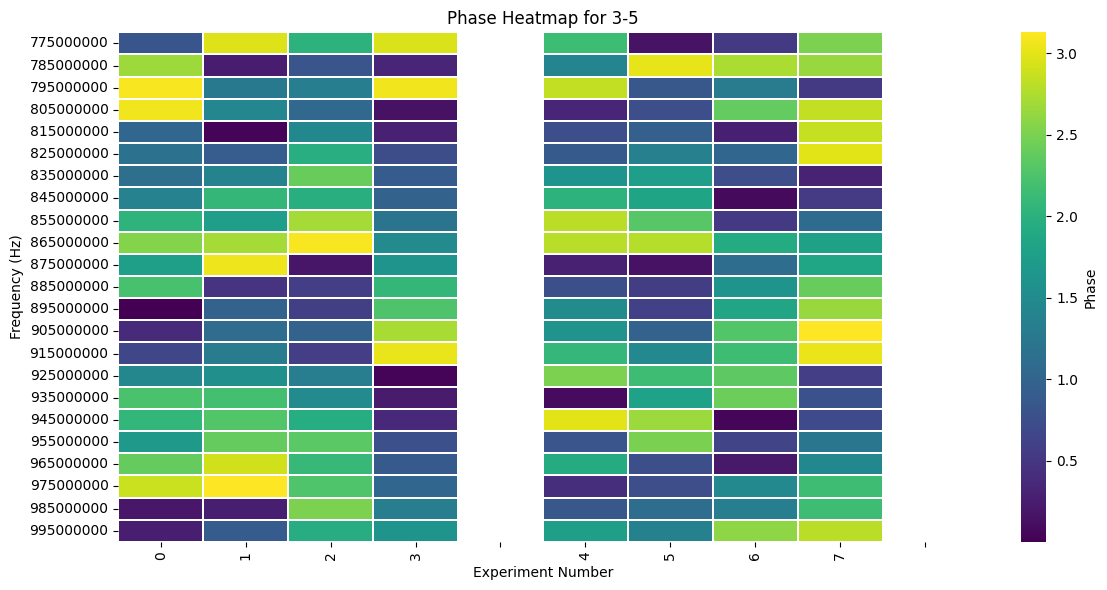

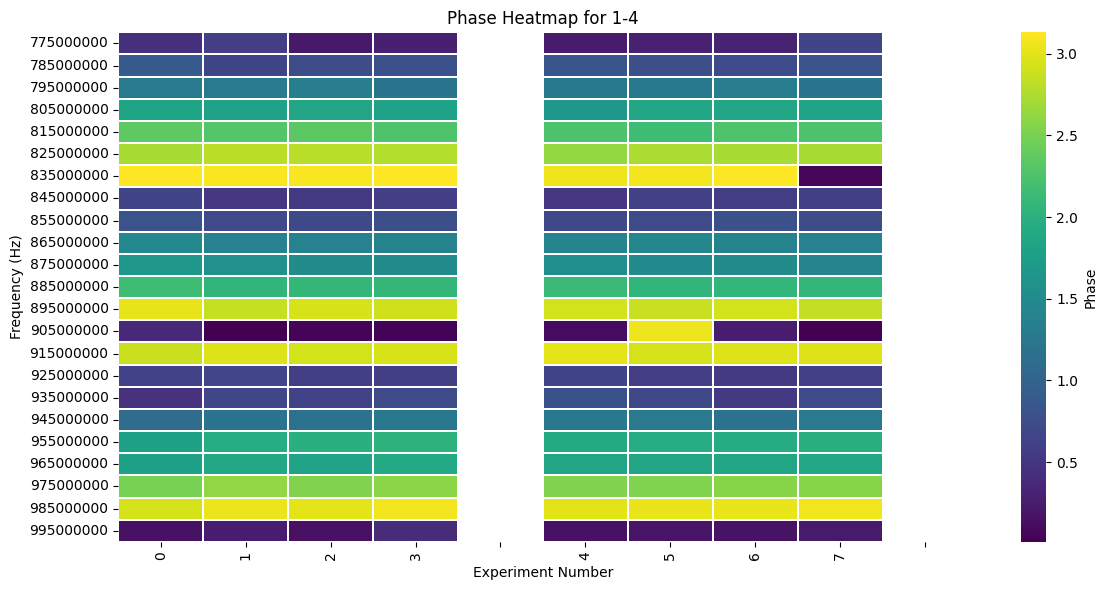

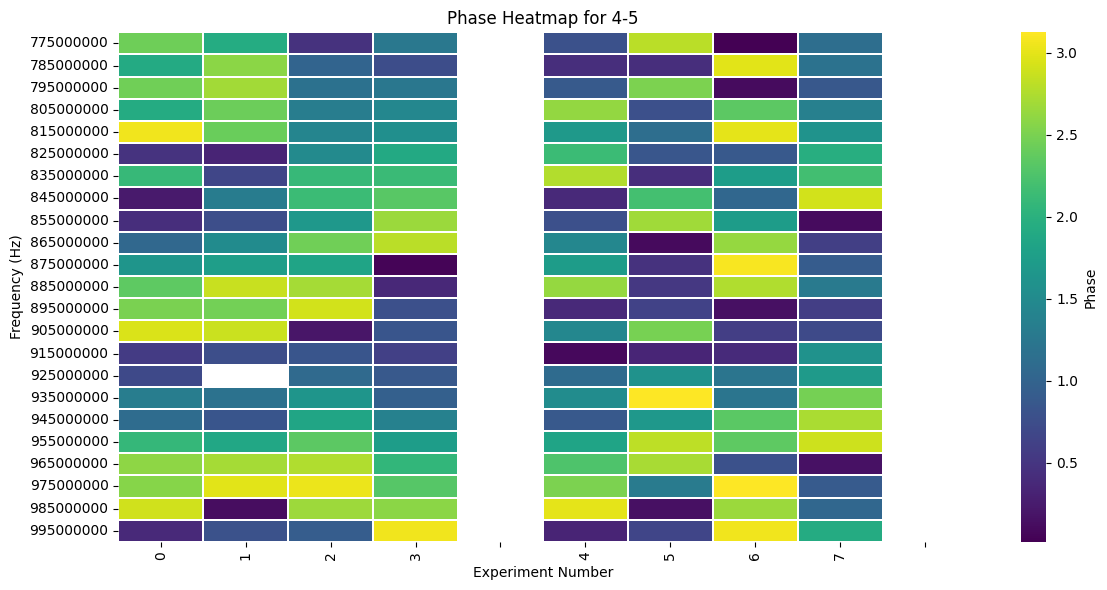

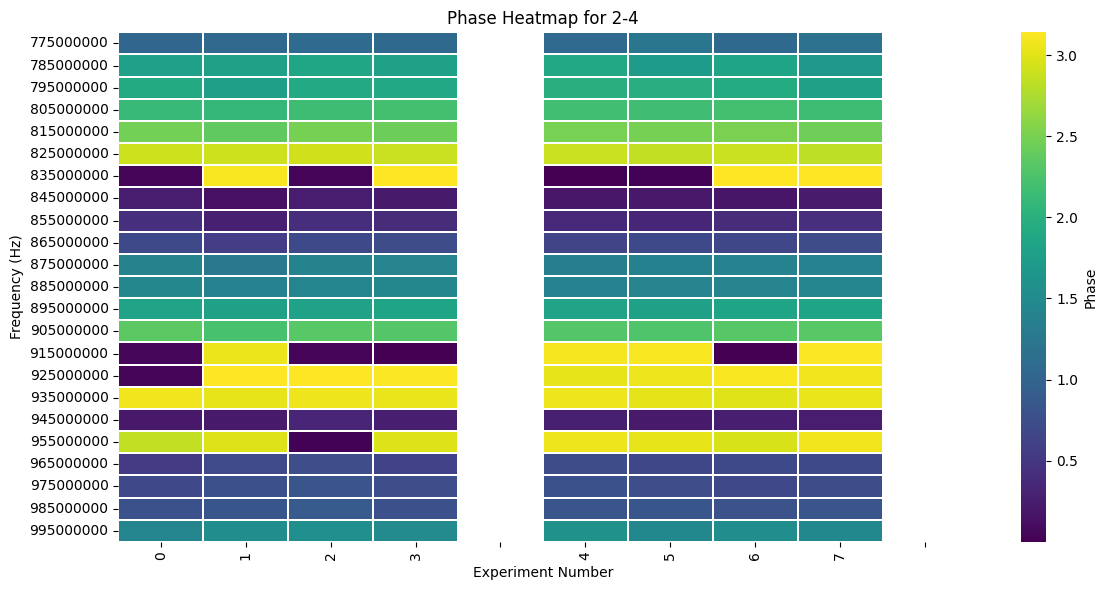

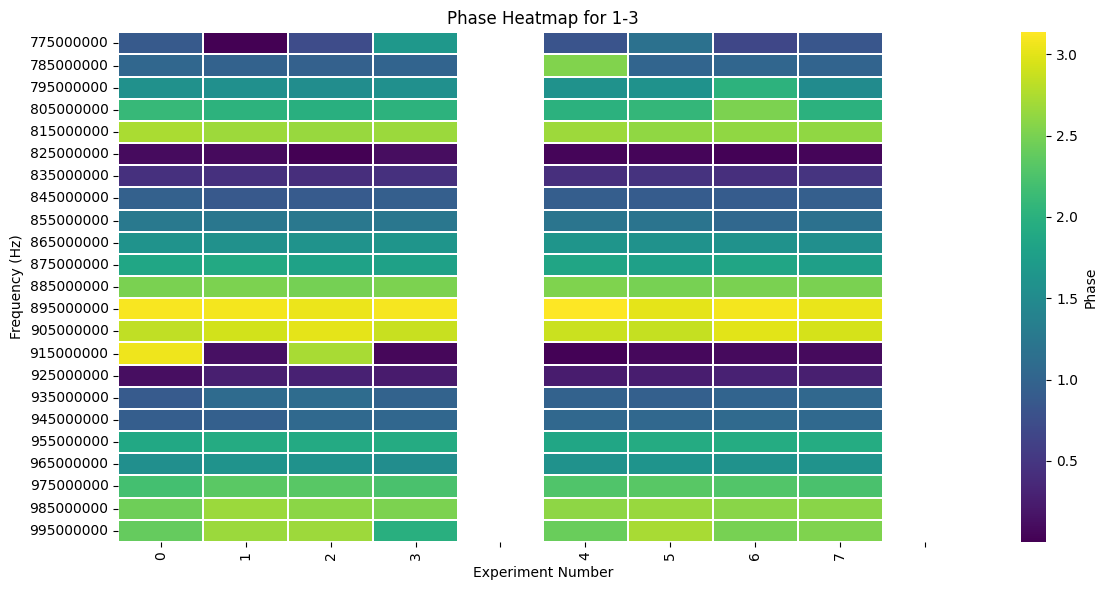

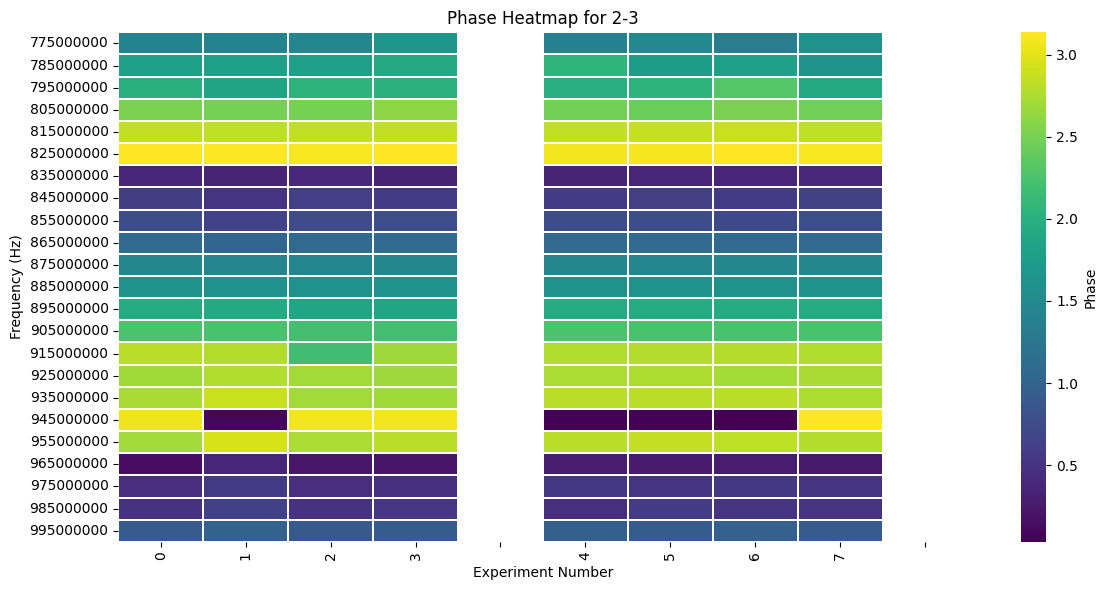

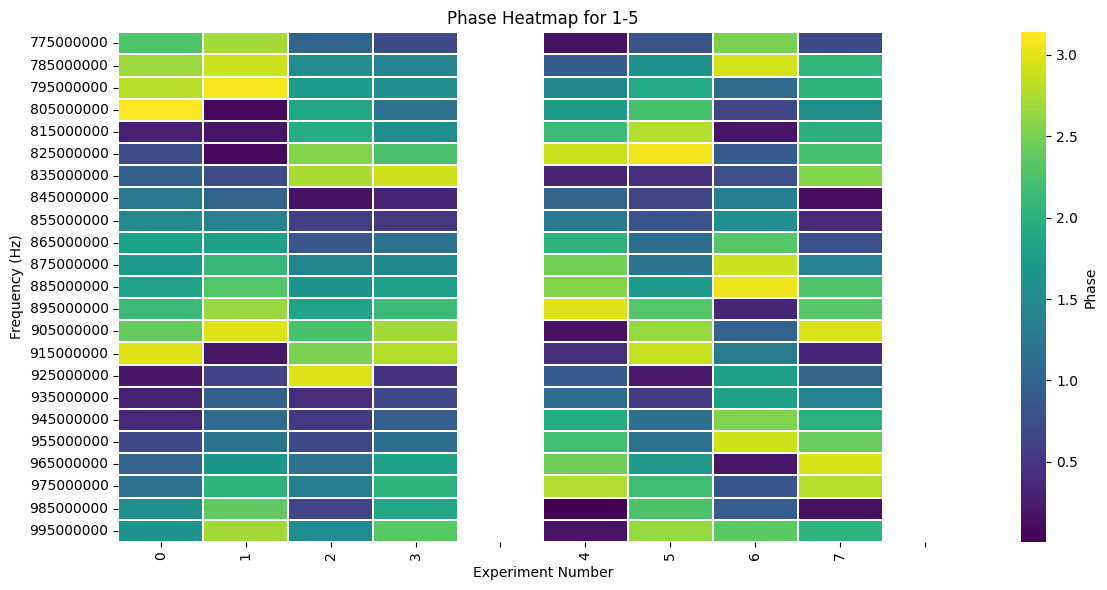

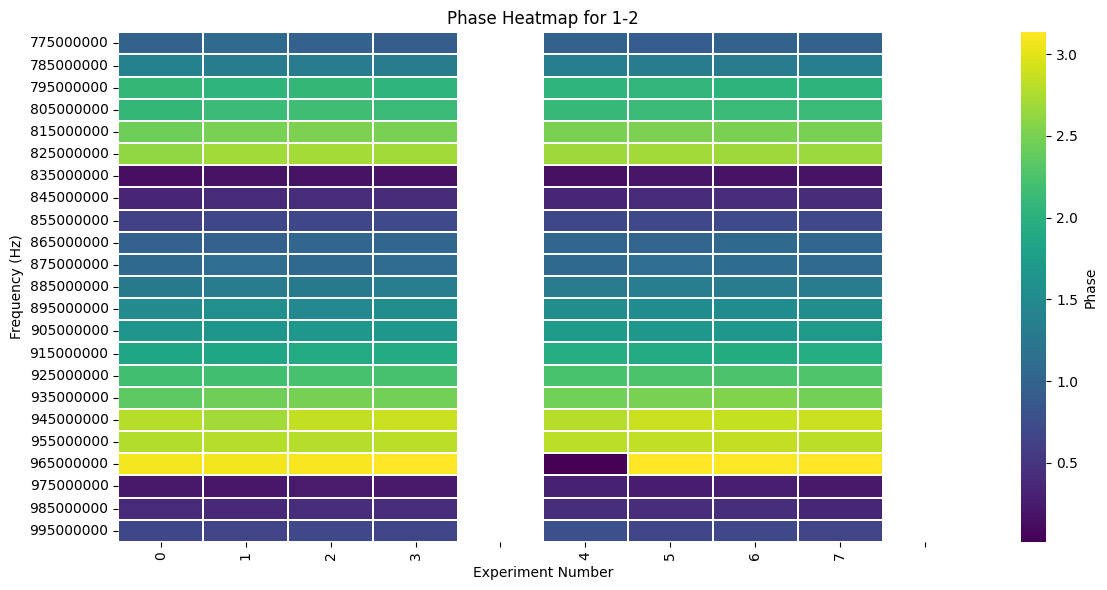

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def plot_phase_heatmaps(data):
    """
    data format:
    {
        freq: {
            exp_num: [ { "tagA-tagB": phase, ... } ]
        }
    }
    """

    # ---- Extract all tag pairs ----
    tag_pairs = set()
    for freq, exp_dict in data.items():
        for exp, tag_list in exp_dict.items():
            tag_pairs.update(tag_list[0].keys())

    frequencies = sorted(data.keys())
    experiment_numbers = sorted({exp for freq in data for exp in data[freq]})

    # ---- Build spacing-aware X-axis ----
    original_exps = experiment_numbers.copy()
    spaced_exps = []
    insert_positions = set()

    for i, exp in enumerate(experiment_numbers):
        spaced_exps.append(exp)
        if (i + 1) % 4 == 0:      # after every 4th experiment
            spaced_exps.append("")   # spacer label
            insert_positions.add(len(spaced_exps) - 1)

    # ---- Create heatmap for each tag ----
    for tag in tag_pairs:

        # Initialize heat matrix
        heat = np.full((len(frequencies), len(spaced_exps)), np.nan)

        for i, f in enumerate(frequencies):

            col = 0
            for j, exp in enumerate(original_exps):

                # Fill actual experiment column
                if exp in data[f]:
                    tag_dict = data[f][exp][0]
                    if tag in tag_dict:
                        heat[i, col] = tag_dict[tag]

                col += 1

                # If a spacer should be added here, skip one column
                if (j + 1) % 4 == 0:
                    col += 1

        # ---- Plot heatmap ----
        plt.figure(figsize=(12, 6))
        sns.heatmap(
            heat,
            xticklabels=spaced_exps,
            yticklabels=frequencies,
            cmap="viridis",
            cbar_kws={"label": "Phase"},
            linewidths=0.2,
            linecolor="white"  # makes spacers more visible
        )

        plt.xlabel("Experiment Number")
        plt.ylabel("Frequency (Hz)")
        plt.title(f"Phase Heatmap for {tag}")

        # Rotate labels
        plt.xticks(rotation=90)

        plt.tight_layout()
        plt.show()

plot_phase_heatmaps(all_freqs)